<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/SentimentAnalysisBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install kaggle --quiet
# ! mkdir ~/.kaggle
# ! chmod 600 ~/.kaggle/kaggle.json

# Sentiment Analysis using BERT

## Importing necessary packages

In [44]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy

from wordcloud import WordCloud
import torch
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [3]:
%%time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

import kagglehub

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 2.41 s, sys: 240 ms, total: 2.65 s
Wall time: 4.66 s


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [5]:
%%time
path = kagglehub.dataset_download("nelgiriyewithana/emotions")

print("Path to dataset files:", path)

100%|██████████| 15.7M/15.7M [00:00<00:00, 75.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nelgiriyewithana/emotions/versions/1
CPU times: user 1.22 s, sys: 113 ms, total: 1.33 s
Wall time: 3.01 s


In [6]:
os.listdir(path)

['text.csv']

In [7]:
%%time
data = pd.read_csv(path+'/text.csv',usecols=['text','label'])
data.head()

CPU times: user 728 ms, sys: 86.2 ms, total: 814 ms
Wall time: 809 ms


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [8]:
labelMap = {0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

In [9]:
%%time
fnx = lambda x:labelMap[x['label']]
data = data.assign(labelTone = data.apply(fnx,axis=1))
data.head()

CPU times: user 2.53 s, sys: 36.1 ms, total: 2.57 s
Wall time: 2.58 s


,text,label,labelTone
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       416809 non-null  object
 1   label      416809 non-null  int64 
 2   labelTone  416809 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


## Data Exploration

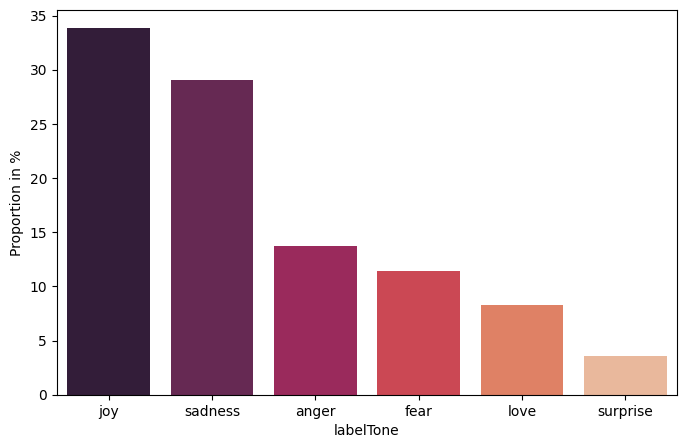

In [11]:
cmap = 'rocket'

plt.figure(figsize=(8,5),dpi=100)
sns.barplot(data['labelTone'].value_counts(normalize=True)*100, palette=cmap)
plt.ylabel("Proportion in %")
plt.show()

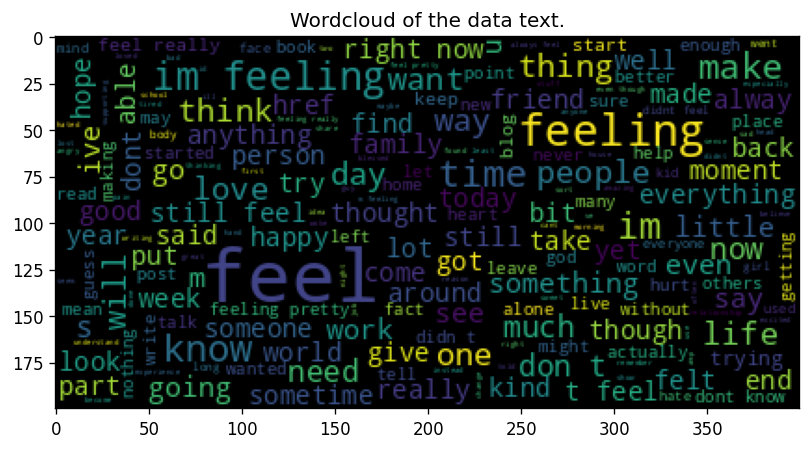

CPU times: user 22.6 s, sys: 1.17 s, total: 23.7 s
Wall time: 23.8 s


In [12]:
%%time
wordcloud = WordCloud(background_color ='black', max_words=200, max_font_size=40, scale=1).generate(" ".join(data['text'].values))

plt.figure(figsize=(8,7),dpi=120)
plt.imshow(wordcloud)
plt.title("Wordcloud of the data text.")
plt.show()

In [16]:
%%time
fnx = lambda row:len(row['text'].split(' '))
data = data.assign(wordlen = data.apply(fnx,axis=1))

fnx = lambda row:len(row['text'])
data = data.assign(charlen = data.apply(fnx,axis=1))

data.head()

CPU times: user 6.27 s, sys: 55.3 ms, total: 6.33 s
Wall time: 7.34 s


,text,label,labelTone,wordlen,charlen
0,i just feel really helpless and heavy hearted,4,fear,8,45
1,ive enjoyed being able to slouch about relax a...,0,sadness,45,234
2,i gave up my internship with the dmrg and am f...,4,fear,12,63
3,i dont know i feel so lost,0,sadness,7,26
4,i am a kindergarten teacher and i am thoroughl...,4,fear,42,222


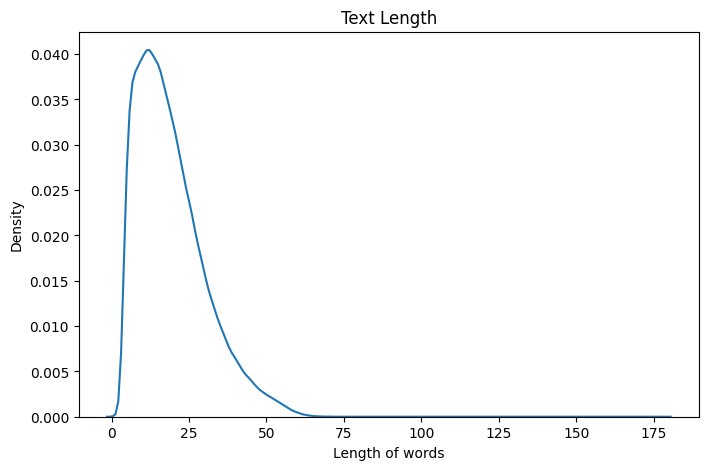

In [20]:
plt.figure(figsize=(8,5),dpi=100)
# sns.histplot(data=data, x='wordlen',hue='labelTone',binwidth=5)
sns.kdeplot(data=data, x='wordlen')
plt.xlabel("Length of words")
plt.title("Text Length")
plt.show()

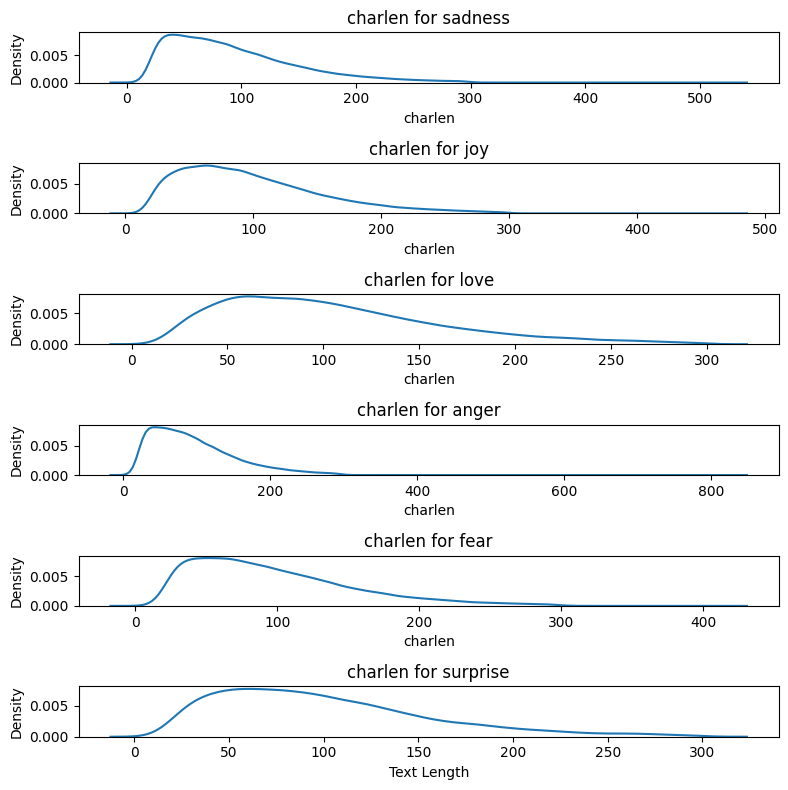

In [22]:
measure = 'wordlen'
measure = 'charlen'

fig,ax = plt.subplots(data['label'].nunique(),1, figsize=(8,8))
for lab in data['label'].unique():
  sns.kdeplot(data=data[data['label']==lab], x=measure,ax=ax[lab])
  ax[lab].set_title(f"{measure} for {labelMap[lab]}")

fig.tight_layout()
plt.xlabel("Text Length")
plt.show()

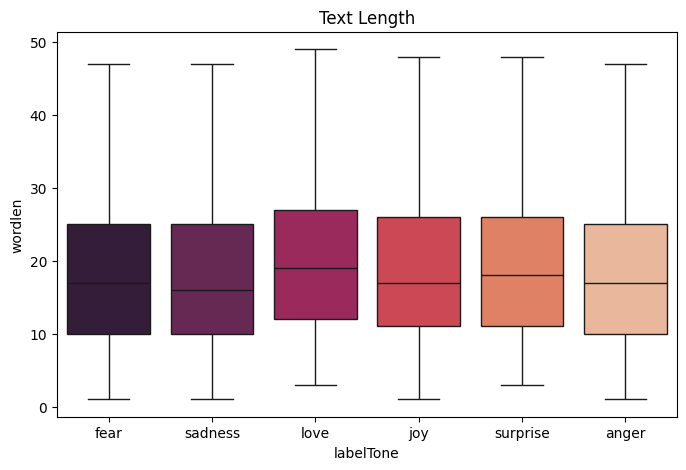

In [ ]:
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=data,x='labelTone', y='wordlen', palette=cmap,showfliers=False)
plt.title("Text Length")
plt.show()

In [45]:
%%time
texts = data['text'].str.split().values.tolist()
corpus = [word for i in texts for word in i]

corpus = Counter(corpus)

CPU times: user 6.57 s, sys: 706 ms, total: 7.28 s
Wall time: 8.03 s


In [58]:
n = 100

wordCommon,countCommon = [],[]
for word in corpus.most_common(n=n):
  if word[0] not in stopWords_nltk:
    wordCommon.append(word[0])
    countCommon.append(word[1])

print("Common Words:", len(wordCommon))

Most Common Words: 30


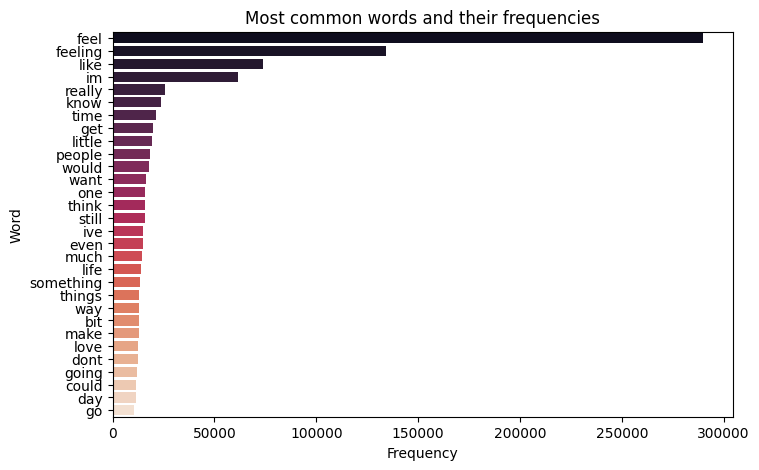

In [60]:
plt.figure(figsize=(8,5),dpi=100)
sns.barplot(x=countCommon, y=wordCommon, palette=cmap)
plt.title("Most common words and their frequencies")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

## BERT

In [23]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
tokenizer("i just feel really helpless and heavy hearted")

{'input_ids': [101, 1045, 2074, 2514, 2428, 13346, 1998, 3082, 18627, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [30]:
%%time
fnx = lambda row: tokenizer(row['text'], add_special_tokens=False)['input_ids']

dataToken = data.apply(fnx, axis=1)

CPU times: user 5min 2s, sys: 1.12 s, total: 5min 3s
Wall time: 5min 25s
